<a href="https://colab.research.google.com/github/aviaga/FutureMakers/blob/main/ML%20Secondary/NLPs%3A%20Movie%20Review%20Sentiment%20Analysis%20(7-28).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Intro
This is the implementation of Day 23's Action Item for SureStart's summer program, 2021.

The goal of this activity is to build a model that performs text classification. Specifically, this model will do sentiment analysis to classify if a given movie review is positive or negative.  

The tutorial for this model development activity can be found [here](https://www.tensorflow.org/tutorials/keras/text_classification).

In [1]:
#Importing libraries
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

**Downloading and experimenting with the data**

In [2]:
#Downloading data 
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84131840/84125825 [==============================] - 2s 0us/step


In [3]:
#Seeing what is in the directory
os.listdir(dataset_dir) 

['test', 'imdb.vocab', 'imdbEr.txt', 'train', 'README']

In [4]:
#Looking at the folders within "train" directory
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['pos',
 'urls_neg.txt',
 'unsup',
 'urls_unsup.txt',
 'urls_pos.txt',
 'neg',
 'unsupBow.feat',
 'labeledBow.feat']

In [5]:
#Taking a look at a positive movie review
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


**Loading and Preparing Data**

In [6]:
#Removing unnecessary folders within the directory (only keeping the positive and negative reviews and nothing else)
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [7]:
#Allocating space for a validation set (training and test already exist)
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [8]:
#Simple training of model
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [9]:
#Seeing what the labels for above section mean
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [10]:
#Creating a validation set
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [11]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


**Data Preprocessing and Preparation**

In [12]:
#Defining and creating a function to get rid of html styling, as seen in the simple training visualization earlier
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [13]:
#Standardizing, tokenizing, and vectorizing data
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)
    

In [14]:
#Creating a text only dataset and then calling the "adapt" function to convert strings into integers
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [15]:
#Defining a function to visualize the "adapt" encoding
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [16]:
#FOR VISUAL/USER purposes: Calling the above function to retrieve a batch from dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review) #The review as raw text
print("Label", raw_train_ds.class_names[first_label]) #Category of review - positive or negative
print("Vectorized review", vectorize_text(first_review, first_label)) #Review (specifically, each word in the review) encoded into an array/vector of integers

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [17]:
#FOR VISUAL/USER PURPOSES: Seeing what a few of the integers map to 
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [18]:
#Applying vectorization to all datasets
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

**Data Configuration**

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Building the model**

In [20]:
#Defining model architecture (layers)
embedding_dim = 16

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [21]:
#Defining model architecture (optimizer and loss function)
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

**Model Training**

In [22]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 13s 19ms/step - loss: 0.6643 - binary_accuracy: 0.6956 - val_loss: 0.6156 - val_binary_accuracy: 0.7714
Epoch 2/10
625/625 [==============================] - 4s 7ms/step - loss: 0.5492 - binary_accuracy: 0.8005 - val_loss: 0.4986 - val_binary_accuracy: 0.8224
Epoch 3/10
625/625 [==============================] - 4s 7ms/step - loss: 0.4449 - binary_accuracy: 0.8460 - val_loss: 0.4201 - val_binary_accuracy: 0.8470
Epoch 4/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3791 - binary_accuracy: 0.8662 - val_loss: 0.3738 - val_binary_accuracy: 0.8604
Epoch 5/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3355 - binary_accuracy: 0.8799 - val_loss: 0.3449 - val_binary_accuracy: 0.8672
Epoch 6/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3047 - binary_accuracy: 0.8877 - val_loss: 0.3259 - val_binary_accuracy: 0.8714
Epoch 7/10
625/625 [==============================] - 4s 7ms/s

**Evaluating and Visualing Results**

In [23]:
#Evaluating model loss and accuracy
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 10s 12ms/step - loss: 0.3104 - binary_accuracy: 0.8729
Loss:  0.31042030453681946
Accuracy:  0.8729199767112732


In [24]:
#Seeing files made in model training
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [25]:
#Assigning data to variables for next steps
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)


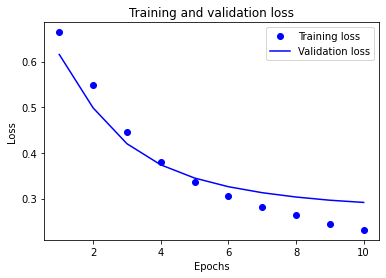

In [26]:
#Plotting training and validation loss of model
plt.plot(epochs, loss, 'bo', label='Training loss') #Data points
plt.plot(epochs, val_loss, 'b', label='Validation loss') #Line
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

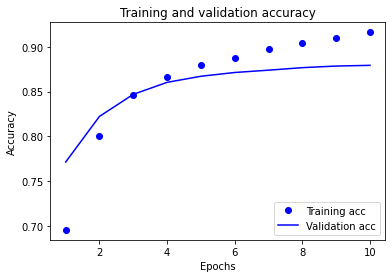

In [27]:
#Plotting training and validation accuracy of model
plt.plot(epochs, acc, 'bo', label='Training acc') #Data points
plt.plot(epochs, val_acc, 'b', label='Validation acc') #Line
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

**Export model**

In [28]:
#Creating another model with Text Vectorization within architecture for easier deployment
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds` (yields raw strings)
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 10s 12ms/step - loss: 0.3104 - accuracy: 0.8729
0.8729199767112732


In [29]:
#Allowing model to make predictions on new samples (higher = positive, lower = negative)
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible."
]
export_model.predict(examples)

array([[0.61886925],
       [0.44126934],
       [0.35998693]], dtype=float32)